In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import collections
from tqdm import tqdm
from copy import deepcopy

import seaborn as sns

sns.set_style('whitegrid')


In [2]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]

    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images,
                        2).reshape(images.shape[0], -1).mean(axis=-1)

    ind_1 = (digits == 1)
    ind_not_1 = (digits != 1)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_not_1] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]),
                              axis=1)
    return features, labels


# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

# ----------------------------- combine the data ----------------------------- #
features = np.concatenate((features_train, features_test), axis=0)
labels = np.concatenate((labels_train, labels_test), axis=0)


In [3]:
# normalize features
import sklearn.preprocessing as preprocessing

features = preprocessing.MinMaxScaler(
    feature_range=(-1, 1)).fit_transform(features)

# split test and train
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=300, random_state=78)


# standardize features
standardizer = preprocessing.StandardScaler().fit(features_train)
features_train = standardizer.fit_transform(features_train)
features_test = standardizer.transform(features_test)

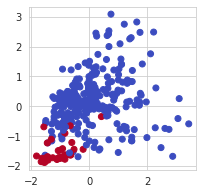

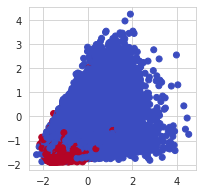

In [4]:
# plot features and labels
plt.figure(figsize=(3, 3))
plt.scatter(features_train[:, 0],
            features_train[:, 1],
            c=labels_train,
            cmap='coolwarm')
plt.figure(figsize=(3, 3))
plt.scatter(features_test[:, 0],
            features_test[:, 1],
            c=labels_test,
            cmap='coolwarm')

In [5]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf,
                           features_train,
                           labels_train,
                           title='decision boundary'):
    cmap_light = ListedColormap(["orange", "green"])
    cmap_dark = ListedColormap(["darkorange", "darkgreen"])

    xx, yy = np.meshgrid(np.arange(-2, 2, 0.02), np.arange(-2, 2, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(features_train[:, 0],
                features_train[:, 1],
                c=labels_train,
                s=30,
                cmap=cmap_dark,
                edgecolors="black")
    plt.title(title)


class Dataset():
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

class DataLoader():
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.total_size = len(dataset)

    def __iter__(self):
        self.batch_index = 0
        return self

    def __len__(self):
        return int(np.ceil(self.total_size * 1.0 / self.batch_size))

    def __next__(self):
        if self.batch_index == 0:
            if self.shuffle:
                indices = np.random.permutation(self.total_size)
                self.dataset.features = self.dataset.features[indices]
                self.dataset.labels = self.dataset.labels[indices]

        if self.batch_index >= self.total_size:
            raise StopIteration

        end_index = min(self.batch_index + self.batch_size, self.total_size)
        batch_features = self.dataset.features[self.batch_index:end_index]
        batch_labels = self.dataset.labels[self.batch_index:end_index]
        self.batch_index = (self.batch_index + self.batch_size)
        return batch_features, batch_labels

In [6]:
# class Metrics(object):
#     def __init__(self, log_interval=100) -> None:
#         self.losses = []
#         self.accuracies = []
#         self.log_interval = log_interval

#     def update(self, loss, acc):
#         self.losses.append(loss)
#         self.accuracies.append(acc)

#     def get_latest_metrics(self):
#         _loss = np.mean(self.losses[-self.log_interval:])
#         _acc = np.mean(self.accuracies[-self.log_interval:])
#         return _loss, _acc
class Metrics(object):
    def __init__(self, log_interval=100) -> None:
        self.losses = []
        self.losses_ = []
        self.precisions = []
        self.recalls = []
        self.accuracies = []
        self.log_interval = log_interval

    def update(self, loss, acc, prec, rec):
        self.losses_.append(loss)
        # self.losses.append(np.mean(self.losses_[-10:]))
        self.losses.append(loss)
        self.precisions.append(prec)
        self.recalls.append(rec)
        self.accuracies.append(acc)

    def get_latest_metrics(self):
        _loss = np.mean(self.losses_[-self.log_interval:])
        _acc = np.mean(self.accuracies[-self.log_interval:])
        _prec = None  # np.mean(self.precisions[-self.log_interval:])
        _rec = None  # np.mean(self.recalls[-self.log_interval:])
        return _loss, _acc, _prec, _rec


In [7]:
class NNLayer:
    def __init__(self,
                 dims=[2, 10, 1],
                 eps=1,
                 weight_decay=0,
                 theta=np.tanh,
                 theta_prime=lambda x: 1 - np.tanh(x)**2) -> None:
        self.W = []
        for i in range(len(dims)-1):
            # self.W.append(np.ones((dims[i]+1, dims[i+1])))
            self.W.append(eps * np.random.random((dims[i]+1, dims[i+1])))

        self.weight_decay = weight_decay
        self.theta = theta
        self.theta_prime = theta_prime
        self.grad_W = []

    @property
    def params(self):
        return self.W

    def set_params(self, state_dict):
        self.W = state_dict

    def get_params(self):
        return self.W

    def forward(self, x, W=None):
        # first forward pass
        if W is None:
            W = self.W
        num_layer = len(W)
        a = x
        self.input = x
        s_list = []
        a_list = []
        for i in range(num_layer):
            s = np.dot(np.append(a, 1), W[i])
            if i == num_layer - 1:
                a = s
            else:
                a = self.theta(s)
            s_list.append(s)
            a_list.append(a)

        self.a_list = a_list
        self.s_list = s_list
        return a

    def step(self, lr=0.01):
        for i in range(len(self.W)):
            self.W[i] = self.W[i] - lr * self.grad_W[i]
        return self.W

    def calc_loss(self, pred, y, weight_decay=None):
        # calculate loss
        loss = np.mean(1/4. * (pred - y)**2)
        if weight_decay is not None:
            loss += (weight_decay * np.sum(self.W**2))
        return loss

    def calc_grad(self, x, y):
        pred = self.forward(x)
        loss = self.calc_loss(pred, y)

        self.d_list = []

        # compute sensitivity
        d = 1. / 4 * 2 * (pred - y)
        self.d_list.append(d)
        for l in range(len(self.W) - 2, -1, -1):
            # print(l)
            d = self.W[l+1][:-1].dot(d) * self.theta_prime(self.s_list[l])
            self.d_list.append(d)
        self.d_list = list(reversed(self.d_list))

        # gradient descent: calculate gradient G1, G2
        G_list = []
        for i in range(len(self.W)):
            if i == 0:
                a = self.input
            else:
                a = self.a_list[i-1]
            a = np.append(a, 1)
            G = a[:, None] @ self.d_list[i][:, None].T
            G_list.append(G)

        self.grad_W = G_list
        return G_list, loss, pred

    def calc_grad_numerical(self, x, y, eps=1e-4):
        G_list = []

        for l in range(len(self.W)):
            r, c = self.W[l].shape
            G = np.zeros((r, c))
            for i in range(r):
                for j in range(c):
                    W_copy = deepcopy(self.W)
                    W_copy[l][i, j] += eps
                    pred_plus = self.forward(x, W_copy)
                    loss_plus = self.calc_loss(pred_plus, y)
                    W_copy[l][i, j] -= 2 * eps
                    pred_minus = self.forward(x, W_copy)
                    loss_minus = self.calc_loss(pred_minus, y)
                    G[i, j] = (loss_plus - loss_minus) / (2 * eps)
            G_list.append(G)
        return G_list, None

    def predict(self, X):
        if len(X.shape) == 1:
            return self.predict(X[None])[0]
        preds = []
        for x in X:
            pred = self.forward(x)
            pred = np.sign(pred)
            preds.append(pred)
        return np.concatenate(preds)

    def forward_loss(self, X, Y):
        GG = None
        N = len(X)
        Losses = None
        Pred = []
        for x, y in zip(X, Y):
            G_list, loss, pred = self.calc_grad(x, y)
            Pred.append(pred)
            if GG is None:
                GG = [1. / N * g for g in G_list]
                Losses = 1. / N * loss
            else:
                for i in range(len(GG)):
                    GG[i] += 1. / N * G_list[i]
                Losses += 1. / N * loss
        Pred = np.concatenate(Pred)
        return Losses, Pred, GG

    def forward_loss_no_grad(self, X, Y, W=None, weight_decay=None):
        N = len(X)
        Losses = 0
        Pred = []
        for x, y in zip(X, Y):
            pred = self.forward(x, W)
            loss = self.calc_loss(pred, y)
            Pred.append(pred)
            Losses += 1. / N * loss

        Pred = np.concatenate(Pred)
        return Losses, Pred

    def step(self, GG, lr):
        for i in range(len(self.W)):
            self.W[i] -= lr * GG[i]

    def get_updated_params(self, GG, lr=0.01):
        import copy
        params_new = copy.deepcopy(self.W)
        for i in range(len(params_new)):
            params_new[i] = self.W[i] -  lr * GG[i]
        return params_new


class Trainer(object):
    def __init__(self,
                 model,
                 lr=1e-3,
                 alpha=1.05,
                 beta=0.8,
                 weight_decay=0.01 / 300) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.current_lr = lr
        self.alpha = alpha
        self.beta = beta
        self.weight_decay = weight_decay

    def train_batch(self, X, Y):
        loss, preds, grads = self.model.forward_loss(X,Y)
        self.model.step(grads, lr=self.current_lr)
        return loss, preds

    def train_batch_var_lr(self, X, Y):
        # self.model.train()
        loss, preds, grads = self.model.forward_loss(X,Y)

        params_new = self.model.get_updated_params(grads, lr=self.current_lr)
        loss_new, _ = self.model.forward_loss_no_grad(X, Y, params_new)
        if loss_new < loss:
            self.model.step(grads, lr=self.current_lr)
            self.current_lr = self.current_lr * self.alpha
        else:
            self.current_lr = self.current_lr * self.beta
        return loss, preds

    def calc_metrics(self, y, pred):
        pred = np.sign(pred)
        return np.mean(y == pred), None, None

    def predict_loss(self, X, Y):
        loss, preds = self.model.forward_loss_no_grad(
            X, Y, weight_decay=self.weight_decay)
        return loss, preds

    def predict(self, X):
        preds = self.model.predict(X)
        return preds



Training: 1002it [00:09, 104.11it/s, loss=0.0316, acc=0.953, lr=1.22]                         


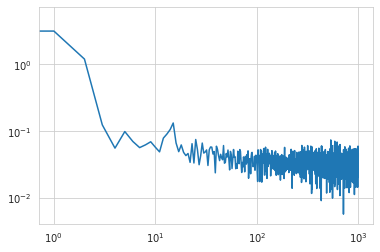

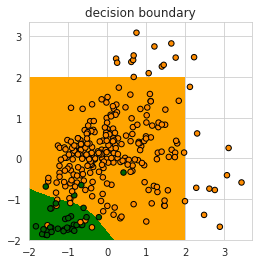

In [8]:
# ------------- variable learning rate gradient descent heuristic ------------ #
model = NNLayer(dims=[2, 10, 1], eps=1)

bs = 100
dataset = Dataset(features_train, labels_train)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

lr = 1
trainer = Trainer(model, lr=lr, alpha=1.05, beta=0.6, weight_decay=None)

log_interval = int(len(dataloader))
metrics = Metrics(log_interval=log_interval)

max_iter = int(1e3)
iteration = 0
obar = tqdm(range(max_iter), desc='Training')

while iteration < max_iter:
    # for ep in range(int(max_iter)):
    for i, (x, y) in enumerate(iter(dataloader)):
        loss, preds = trainer.train_batch_var_lr(x, y)
        # loss, preds = trainer.train_batch(x, y)
        score, prec, rec = trainer.calc_metrics(y, preds)
        metrics.update(loss, score, prec, rec)
    if iteration % log_interval == 0:
        r_loss, r_acc, r_prec, r_rec = metrics.get_latest_metrics()
        obar.set_postfix({
            'loss': r_loss,
            'acc': r_acc,
            'lr': trainer.current_lr
        })
        obar.update(log_interval)
    iteration += log_interval
obar.close()

fig, ax = plt.subplots(1, 1)
ax.plot(metrics.losses)
ax.set_yscale('log')
ax.set_xscale('log')

plt.figure(figsize=(4, 4))
plot_decision_boundary(trainer, features_train, labels_train)

Training: 1002it [00:11, 89.27it/s, loss=0.0332, acc=0.967, loss_v=0.087, acc_v=0.9, lr=1.39]                         


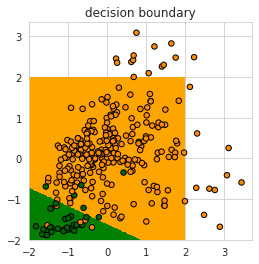

In [9]:
# ------------------------------ early stopping ------------------------------ #
# split train and val
train_features, val_features, train_labels, val_labels = train_test_split(
    features_train, labels_train, test_size=50, random_state=42)

train_dataset = Dataset(
    features_train,
    labels_train)
val_dataset = Dataset(
    val_features,
    val_labels)
bs = 10
dataloader_train = DataLoader(train_dataset,
                                               batch_size=bs,
                                               shuffle=True)
dataloader_val = DataLoader(val_dataset,
                                             batch_size=bs,
                                             shuffle=True)

model = NNLayer(dims=[2, 10, 1], eps=1)

lr = 1
trainer = Trainer(model, lr=lr, alpha=1.05, beta=0.6, weight_decay=0.01 / 300)

log_interval = int(len(dataloader))
metrics = Metrics(log_interval=log_interval)
metrics_val = Metrics(log_interval=log_interval)

max_iter = int(1e3)
iteration = 0
obar = tqdm(range(max_iter), desc='Training')

best_weight = None
best_val_loss = float('inf')
patience = 300
cur_patience = 0

while iteration < max_iter:
    for i, (x, y) in enumerate(dataloader_train):
        loss, preds = trainer.train_batch_var_lr(x, y)
        score, prec, rec = trainer.calc_metrics(y, preds)
        metrics.update(loss, score, prec, rec)

    for i, (x, y) in enumerate(dataloader_val):
        _loss, _preds = trainer.predict_loss(x, y)
        _score, _prec, _rec = trainer.calc_metrics(y, _preds)
        metrics_val.update(_loss, _score, _prec, _rec)

    avg_val_loss = metrics_val.get_latest_metrics()[0]
    if avg_val_loss < best_val_loss:
        best_weight = model.get_params()
        best_val_loss = avg_val_loss
        cur_patience = 0
    else:
        cur_patience += 1

    if cur_patience > patience:
        print(f'Early stopping at {iteration} for val-loss {best_val_loss}')
        model.set_params(best_weight)
        break

    if iteration % log_interval == 0:
        r_loss, r_acc, r_prec, r_rec = metrics.get_latest_metrics()
        vr_loss, vr_acc, *_ = metrics_val.get_latest_metrics()

        obar.set_postfix({
            'loss': r_loss,
            'acc': r_acc,
            'loss_v': vr_loss,
            'acc_v': vr_acc,
            'lr': trainer.current_lr
        })

        obar.update(log_interval)
    iteration += len(dataloader)
obar.close()

plt.figure(figsize=(4, 4))
plot_decision_boundary(trainer, features_train, labels_train)